In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats

In [2]:
df = pd.read_pickle('datos/bikes_limpio.pkl')

In [3]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,sensacion_term,humedad,velocidad_viento,cliente_casual,cliente_registrado,total_clientes
indice,,,,,,,,,,,,,,,
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,2018-05-01,primavera,2018,May,0,Martes,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# IDENTIFICAR OUTLIERS

In [4]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        ´
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(dataframe[col], 25)
        Q3 = np.nanpercentile(dataframe[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices

In [5]:
numericas = df.select_dtypes(include = np.number)

In [6]:
lista_col = list(numericas.columns)

In [7]:
diccionario_outliers = detectar_outliers(lista_col, df)

In [8]:
# iteramos por el diccionarios y cambiamos los outliers por nulos, para posteriormente poder tratarlos
 
for k, v in diccionario_outliers.items():
    for i in v:
        df.loc[i,k] = np.nan # usando el loc, reemmplazamos los valores de los outliers por los nulos 

In [9]:
imputer = IterativeImputer(n_nearest_features = None, 
                           imputation_order = 'ascending')

In [10]:
imputer.fit(numericas)

IterativeImputer()

In [11]:
imputer_trans = imputer.transform (numericas)

In [12]:
df_numericas_trans = pd.DataFrame(imputer_trans, columns = numericas.columns)

In [13]:
#Comprobamos que la transformación ha funcionado

df_numericas_trans.isnull().sum()

temperatura           0
sensacion_term        0
humedad               0
velocidad_viento      0
cliente_casual        0
cliente_registrado    0
total_clientes        0
dtype: int64

In [14]:
#Eliminamos las columnas en el df original (ya tratadas en el df_numéricas) para posteriormente realizar la concatenación

df.drop(df_numericas_trans.columns, axis = 1, inplace=True)

In [15]:
#Concatenamos el df transformado

df_final = pd.concat([df, df_numericas_trans], axis = 1, join = 'inner')

In [19]:
df_final.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,sensacion_term,humedad,velocidad_viento,cliente_casual,cliente_registrado,total_clientes
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.902598,17.68695,69.6087,16.652113,131.0,670.0,801.0
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,8.050924,9.47025,43.7273,16.636703,120.0,1229.0,1349.0
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.200000,10.60610,59.0435,10.739832,108.0,1454.0,1562.0
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,9.305237,11.46350,43.6957,12.522300,82.0,1518.0,1600.0
5,2018-05-01,primavera,2018,May,0,Martes,1,1,8.378268,11.66045,51.8261,6.000868,88.0,1518.0,1606.0


In [21]:
#Comprobamos que la fusión de ambos df ya tratados y limpios no ha generado nulos

df_final.isnull().sum()

fecha                 0
estacion              0
año                   0
mes                   0
festivo               0
dia_semana            0
dia_laboral           0
tiempo                0
temperatura           0
sensacion_term        0
humedad               0
velocidad_viento      0
cliente_casual        0
cliente_registrado    0
total_clientes        0
dtype: int64

## GUARDAR EL DATAFRAME LIMPIO EN DIFERENTES ARCHIVOS

In [22]:
df_final.to_csv('datos/bikes_limpio_final.csv')

In [23]:
df_final.to_pickle('datos/bikes_limpio_final.pkl')

## ASUNCIONES

In [25]:
df = pd.read_pickle('datos/bikes_limpio_final.pkl')

In [26]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,dia_laboral,tiempo,temperatura,sensacion_term,humedad,velocidad_viento,cliente_casual,cliente_registrado,total_clientes
1,2018-01-01,invierno,2018,January,1,Lunes,0,2,14.902598,17.68695,69.6087,16.652113,131.0,670.0,801.0
2,2018-02-01,invierno,2018,February,0,Jueves,1,2,8.050924,9.47025,43.7273,16.636703,120.0,1229.0,1349.0
3,2018-03-01,invierno,2018,March,0,Jueves,1,1,8.200000,10.60610,59.0435,10.739832,108.0,1454.0,1562.0
4,2018-04-01,primavera,2018,April,0,Domingo,0,1,9.305237,11.46350,43.6957,12.522300,82.0,1518.0,1600.0
5,2018-05-01,primavera,2018,May,0,Martes,1,1,8.378268,11.66045,51.8261,6.000868,88.0,1518.0,1606.0


### Evaluamos la normalidad de nuestras VR

- Las gráficas realizadas en el proceso de EDA nos han permitido ver que los datos de nuestras VR no parecían muy normales. No obstante, realizamos shapiro para confirmar.

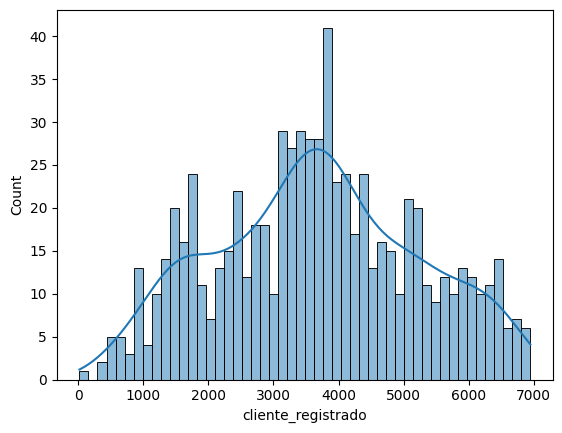

In [28]:
sns.histplot(x='cliente_registrado', data=df, kde=True, bins=50);

In [29]:
stats.shapiro(df['cliente_registrado'])

ShapiroResult(statistic=0.9844226837158203, pvalue=5.26244775755913e-07)

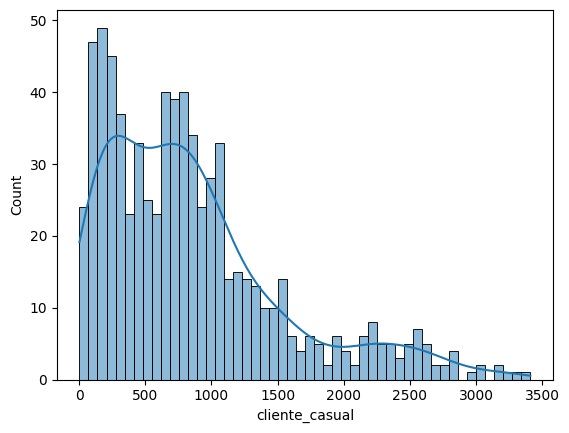

In [30]:
sns.histplot(x='cliente_casual', data=df, kde=True, bins=50);

In [31]:
stats.shapiro(df['cliente_casual'])

ShapiroResult(statistic=0.8853672742843628, pvalue=8.40218526941286e-23)

#### OBSERVACIONES:

- Nuestros datos no son normales:
  - los datos de los clientes_casuales están sesgados a la derecha y la distribución está muy lejos de ser normal.
  - los datos de los clientes_registrados parecen más "normales" pero observando el valor del p-value observamos que es menor que 0.05 y por tanto los datos no son normales tampoco.

 ### NORMALIZACIÓN DE VR